导入相关包

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

读取数据

In [6]:
train=pd.read_csv('E:/course/大三秋/数据科学导引/input/train.tsv', sep='\t',dtype={"index":int,"sentence":int,"phrase":str,"sentiment":int})
test=pd.read_csv('E:/course/大三秋/数据科学导引/input/test.tsv', sep='\t',dtype={"index":int,"sentence":int,"phrase":str,"sentiment":int})
sample_sub = pd.read_csv('E:/course/大三秋/数据科学导引/input/sampleSubmission.csv',dtype={"index":int,"sentence":int,"phrase":str,"sentiment":int})

查看数据情况

In [7]:
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [8]:
test

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


使用词袋模型向量化

In [9]:
# 将短语和标签提取出来
X = train['Phrase']  # 短语
y = train['Sentiment']  # 情感标签

# 将数据拆分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 文本向量化
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

In [ ]:
XGBoost模型

In [10]:
X = X_train_vec
y = y_train

使用XGBoost训练模型，并用optuna调参

In [32]:
import optuna

In [ ]:
# 定义目标函数，用于Optuna调参
def objective(trial):
    # 为XGBClassifier的参数进行采样
    params = {
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.4, 0.8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 0.9),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 6000),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'gamma': trial.suggest_float('gamma', 0.1, 5),
        'random_state': 42
    }
    
    # 创建XGBClassifier
    xgb = XGBClassifier(
        silent=False,
        **params
    )
    
    # 训练模型
    xgb.fit(X_train_vec, y_train)
    
    # 预测测试集
    predictions = xgb.predict(X_val_vec)
    
    # 计算准确率
    accuracy = accuracy_score(y_val, predictions)
    
    # 返回准确率，Optuna将根据此值进行优化
    return accuracy

In [41]:
%%time
#使用optuna调参
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# 输出最佳参数和结果
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print(" Value: {}".format(trial.value))
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

[I 2024-11-24 11:03:50,065] A new study created in memory with name: no-name-82f524c1-b4f3-437c-8131-82f7487ade5f
[I 2024-11-24 11:09:27,259] Trial 0 finished with value: 0.6109509163142381 and parameters: {'scale_pos_weight': 0.6006473355583786, 'learning_rate': 0.09891118807099304, 'colsample_bytree': 0.38534312204559895, 'subsample': 0.7121797863893894, 'n_estimators': 4946, 'reg_alpha': 0.6685787317889744, 'max_depth': 5, 'gamma': 3.9467694643850826}. Best is trial 0 with value: 0.6109509163142381.
[I 2024-11-24 11:13:04,158] Trial 1 finished with value: 0.6326733307702166 and parameters: {'scale_pos_weight': 0.5839445514564013, 'learning_rate': 0.0738037473081925, 'colsample_bytree': 0.1937217887219025, 'subsample': 0.7421060946302614, 'n_estimators': 2043, 'reg_alpha': 0.4203840193310351, 'max_depth': 10, 'gamma': 1.3083655039168633}. Best is trial 1 with value: 0.6326733307702166.
[I 2024-11-24 11:25:43,764] Trial 2 finished with value: 0.6025246699987185 and parameters: {'scale

Number of finished trials:  20
Best trial:
 Value: 0.6495899013200052
 Params: 
 scale_pos_weight: 0.49532624101490497
 learning_rate: 0.07893912053609671
 colsample_bytree: 0.7032087285255331
 subsample: 0.781689529704698
 n_estimators: 3355
 reg_alpha: 0.5267978486476341
 max_depth: 7
 gamma: 0.5521902572655487
CPU times: total: 13h 3min 1s
Wall time: 2h 32min 49s


使用optuna设置20个trial根据准确率调整模型的参数，最终trial 7为最优，准确率为0.6495899对应参数为
Params: 
 scale_pos_weight: 0.49532624101490497
 learning_rate: 0.07893912053609671
 colsample_bytree: 0.7032087285255331
 subsample: 0.781689529704698
 n_estimators: 3355
 reg_alpha: 0.5267978486476341
 max_depth: 7
 gamma: 0.5521902572655487

In [42]:
trial

FrozenTrial(number=7, state=1, values=[0.6495899013200052], datetime_start=datetime.datetime(2024, 11, 24, 11, 56, 37, 533375), datetime_complete=datetime.datetime(2024, 11, 24, 12, 5, 10, 410825), params={'scale_pos_weight': 0.49532624101490497, 'learning_rate': 0.07893912053609671, 'colsample_bytree': 0.7032087285255331, 'subsample': 0.781689529704698, 'n_estimators': 3355, 'reg_alpha': 0.5267978486476341, 'max_depth': 7, 'gamma': 0.5521902572655487}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'scale_pos_weight': FloatDistribution(high=0.8, log=False, low=0.4, step=None), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'subsample': FloatDistribution(high=0.9, log=False, low=0.3, step=None), 'n_estimators': IntDistribution(high=6000, log=False, low=2000, step=1), 'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'max_depth': In

使用调参得到的最佳参数训练模型

In [43]:
parameters={'scale_pos_weight': 0.49532624101490497, 'learning_rate': 0.07893912053609671, 'colsample_bytree': 0.7032087285255331, 'subsample': 0.781689529704698, 'n_estimators': 3355, 'reg_alpha': 0.5267978486476341, 'max_depth': 7, 'gamma': 0.5521902572655487}
xgb = XGBClassifier(silent=False, 
                      **parameters)

In [44]:
%%time
xgb.fit(X_train_vec,y_train)

CPU times: total: 43min 57s
Wall time: 8min 59s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7032087285255331, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5521902572655487,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07893912053609671,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3355, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

对验证集进行预测，评估模型指标

In [45]:
%%time
# Prediction on validation set
y_pred = xgb.predict(X_val_vec)

# Evaluating accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

#classification report
report = classification_report(y_val, y_pred)
print(report)

Validation Accuracy: 0.6493976675637575
              precision    recall  f1-score   support

           0       0.56      0.33      0.41      1416
           1       0.59      0.37      0.45      5527
           2       0.67      0.90      0.77     15639
           3       0.62      0.45      0.52      6707
           4       0.60      0.38      0.47      1923

    accuracy                           0.65     31212
   macro avg       0.61      0.48      0.52     31212
weighted avg       0.64      0.65      0.62     31212

CPU times: total: 2min 11s
Wall time: 21.7 s


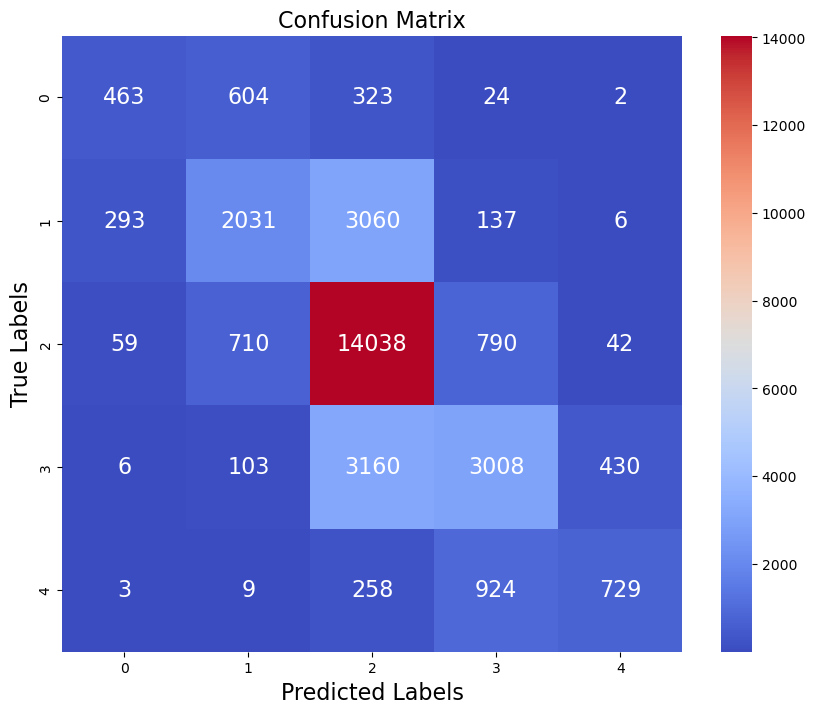

In [46]:
# 绘制混淆矩阵
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels',fontsize=16)
plt.ylabel('True Labels',fontsize=16)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

检查测试集中是否存在NaN

使用<UNK>填补缺失值

In [48]:
X_test=test['Phrase']
#填补缺失值
X_test.fillna('<UNK>', inplace=True)

检查是否存在缺失值，验证填补结果

In [49]:
nan_mask = pd.isnull(X_test)  # 或者使用 pd.isna(X_test)
if nan_mask.any().any():  # 检查是否有任何NaN值
    print("存在NaN值")
else:
    print("不存在NaN值")

不存在NaN值


In [50]:
X_test_vec =vectorizer.transform(X_test)

In [51]:
%%time
# Prediction on test set
xgb_predict=xgb.predict(X_test_vec)

CPU times: total: 4min 49s
Wall time: 52 s


In [52]:
xgb_predict

array([3, 3, 2, ..., 2, 2, 2], dtype=int64)

生成测试结果提交文件

In [53]:
submission_file =pd.read_csv("E:\course\大三秋\数据科学导引\input\sampleSubmission.csv",sep=',')
submission_file['Sentiment']=xgb_predict
submission_file

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3
...,...,...
66287,222348,1
66288,222349,1
66289,222350,2
66290,222351,2


In [54]:
submission_file.to_csv('Submission_XGB.csv',index=False)

在kaggle上提交Submission_XGB.csv，XGBoost模型的预测准确率为0.61932